# Plant Leaf Disease Detection

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.preprocessing import image as keras_image
from scikeras.wrappers import KerasClassifier

In [4]:
import os
import pandas as pd

data_dir = 'leaf2'

# Get a list of all subdirectories within the 'PlantVillage' directory
subdirectories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

image_paths = []
labels = []
subdirectory_col = []  # New column to store subdirectories

for subdirectory in subdirectories:
    class_path = os.path.join(data_dir, subdirectory)
    image_files = os.listdir(class_path)
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        image_paths.append(image_path)
        labels.append(subdirectory)
        subdirectory_col.append(subdirectory)

# Create a DataFrame with image paths, labels, and subdirectories
df = pd.DataFrame({'image_path': image_paths, 'label': labels, 'subdirectory': subdirectory_col})


In [5]:
df.head()

image_path  \
0  leaf2/Orange___Haunglongbing_(Citrus_greening)...   
1  leaf2/Orange___Haunglongbing_(Citrus_greening)...   
2  leaf2/Orange___Haunglongbing_(Citrus_greening)...   
3  leaf2/Orange___Haunglongbing_(Citrus_greening)...   
4  leaf2/Orange___Haunglongbing_(Citrus_greening)...   

                                      label  \
0  Orange___Haunglongbing_(Citrus_greening)   
1  Orange___Haunglongbing_(Citrus_greening)   
2  Orange___Haunglongbing_(Citrus_greening)   
3  Orange___Haunglongbing_(Citrus_greening)   
4  Orange___Haunglongbing_(Citrus_greening)   

                               subdirectory  
0  Orange___Haunglongbing_(Citrus_greening)  
1  Orange___Haunglongbing_(Citrus_greening)  
2  Orange___Haunglongbing_(Citrus_greening)  
3  Orange___Haunglongbing_(Citrus_greening)  
4  Orange___Haunglongbing_(Citrus_greening)

In [6]:
df.shape

(18818, 3)

In [7]:
print("The classes:\n", np.unique(df['label']))

The classes:
 ['Apple___Apple_scab' 'Corn_(maize)___Common_rust_'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Potato_blight' 'Squash___Powdery_mildew'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


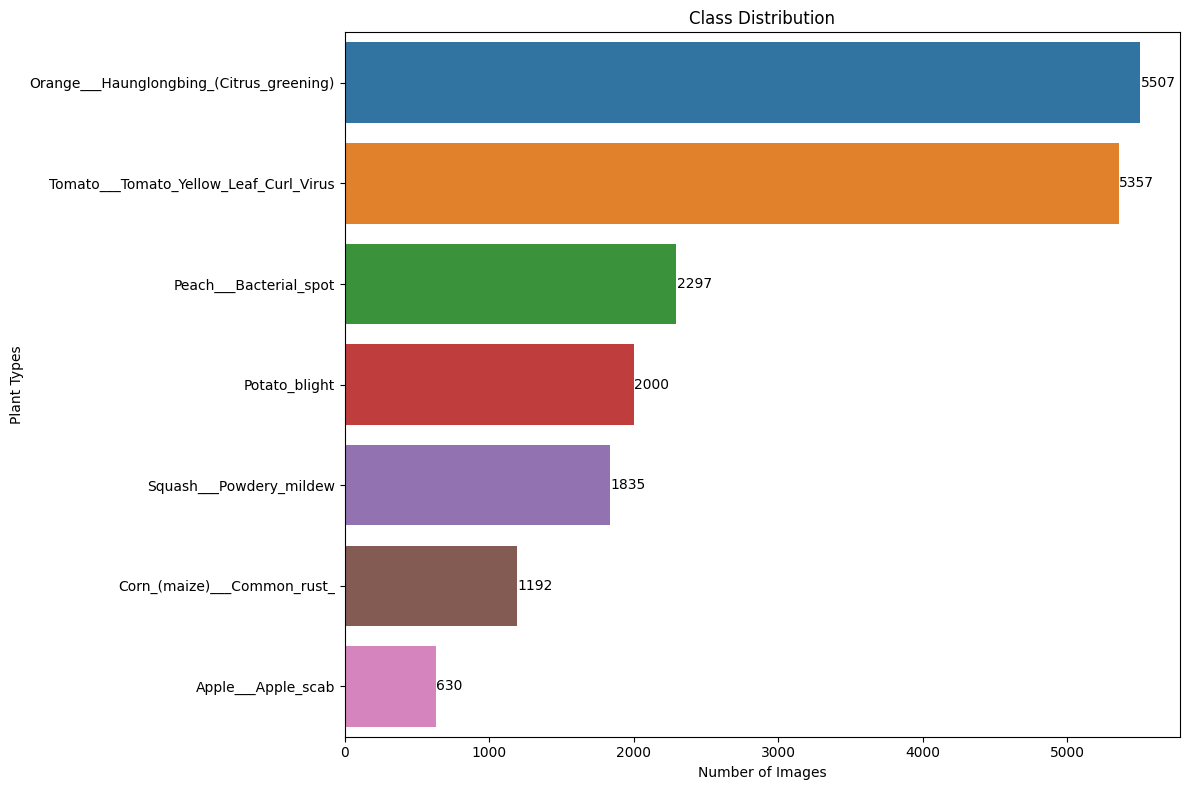

In [8]:
class_counts = df['label'].value_counts()

# Visualize class distribution using a horizontal bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=class_counts.values, y=class_counts.index, orient='h')
plt.title('Class Distribution')
plt.xlabel('Number of Images')
plt.ylabel('Plant Types')
plt.tight_layout()  # Adjust the layout to prevent overlapping labels

# Add data labels to each bar
for i, v in enumerate(class_counts.values):
    ax.text(v + 5, i, str(v), color='black', va='center')

plt.show()

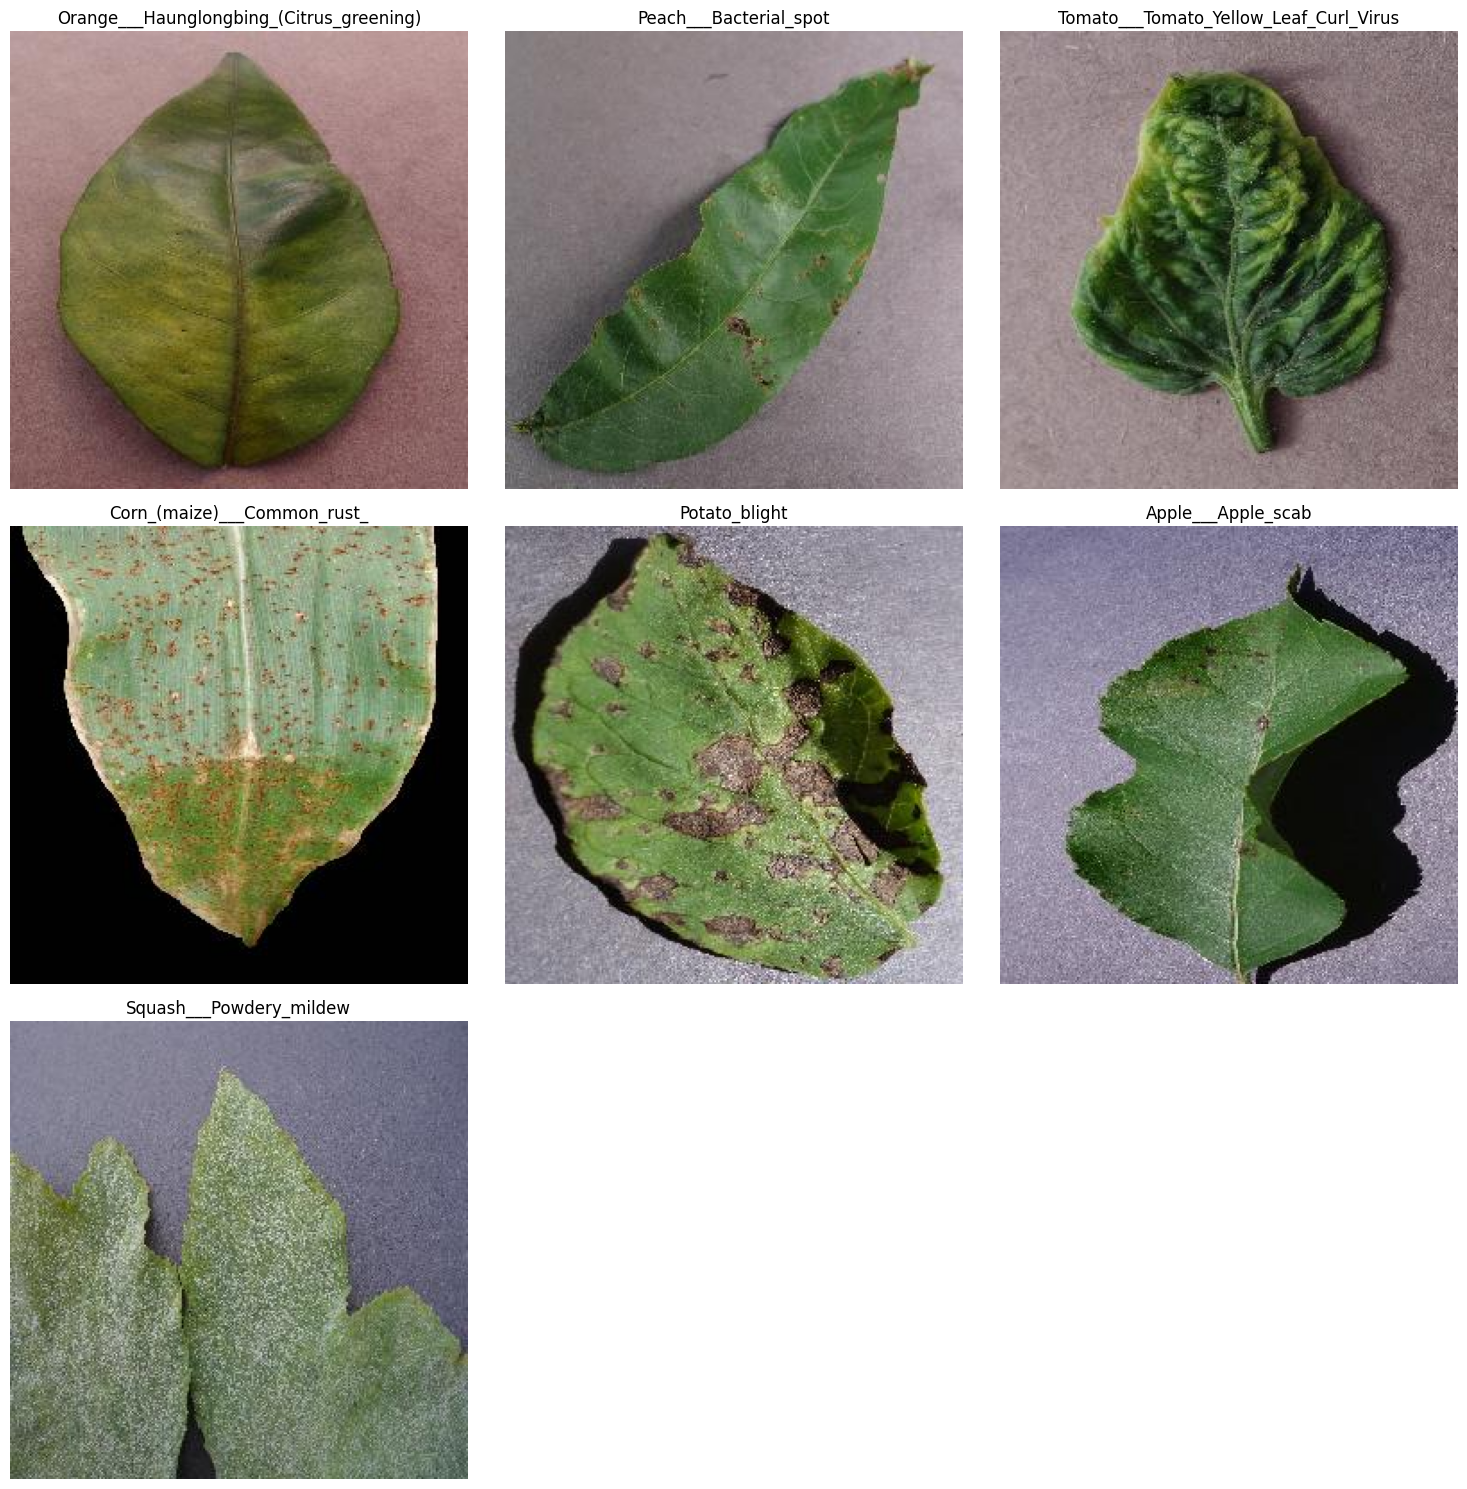

In [9]:
num_classes = len(df['label'].unique())
num_images_per_row = 3
num_rows = (num_classes + num_images_per_row - 1) // num_images_per_row

plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure size based on the number of rows

for i, plant_class in enumerate(df['label'].unique()):
    plt.subplot(num_rows, num_images_per_row, i + 1)

    # Inside the loop for displaying sample images
    image_path = os.path.join(df[df['label'] == plant_class]['image_path'].iloc[0])

    # Check if the image exists and can be loaded
    if os.path.exists(image_path):
        sample_image = cv2.imread(image_path)
        if sample_image is not None:
            plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
            plt.title(plant_class)
            plt.axis('off')
        else:
            print(f"Error: Unable to load image from path: {image_path}")
    else:
        print(f"Error: Image path does not exist: {image_path}")

plt.tight_layout()
plt.show()

In [10]:
class_labels_dict = {class_label: idx for idx, class_label in enumerate(np.unique(df['label']))}
df['label'] = df['label'].map(class_labels_dict)

In [11]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [12]:
train_df.shape, test_df.shape

((15054, 3), (3764, 3))

In [13]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [14]:
train_df.shape, val_df.shape

((12043, 3), (3011, 3))

In [15]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

In [16]:
print(train_df['label'].unique())

['6' '3' '2' '4' '1' '5' '0']


In [17]:
batch_size = 40

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Step 4: Model Selection
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# num_classes = len(class_folders)
num_classes = len(class_labels_dict)


# Step 5: Model Building
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Step 6: Model Training
learning_rate = 0.001
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Found 12043 validated image filenames belonging to 7 classes.
Found 3011 validated image filenames belonging to 7 classes.
Found 3764 validated image filenames belonging to 7 classes.
9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/10
302/302 [==============================] - 217s 605ms/step - loss: 0.1832 - accuracy: 0.9521 - val_loss: 16.9164 - val_accuracy: 0.1209
Epoch 2/10
302/302 [==============================] - 180s 595ms/step - loss: 0.1126 - accuracy: 0.9716 - val_loss: 16.0940 - val_accuracy: 0.0777
Epoch 3/10
302/302 [==============================] - 191s 632ms/step - loss: 0.0590 - accuracy: 0.9835 - val_loss: 10.2295 - val_accuracy: 0.4334
Epoch 4/10
302/302 [==============================] - 181s 600ms/step - loss: 0.0546 - accuracy: 0.9857 - val_loss: 3.7033 - val_accuracy: 0.6509
Epoch 5/10
302/302 [==============================] - 184s 608ms/step - loss: 0.0499 - accuracy: 0.9866 - val_loss: 3.0308 - val_accuracy: 0.7961
Epoch 6/10
302/302 [

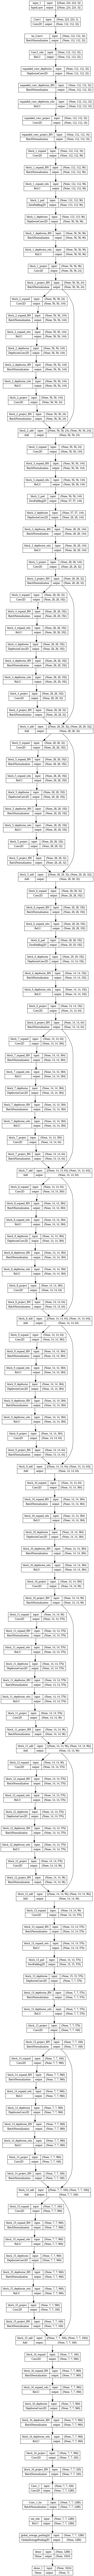

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file= 'model_plot.png', show_shapes = True, show_layer_names=True)

In [19]:
loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}, Test Accuracy: {test_accuracy}")

95/95 [==============================] - 8s 79ms/step - loss: 1.6405 - accuracy: 0.8810
Test Loss: 1.640450119972229, Test Accuracy: 0.8809776902198792


In [20]:
test_predictions = model.predict(test_generator)
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Get the true labels for the test set
test_true_labels = test_generator.classes

# Create a DataFrame for analysis
error_df = pd.DataFrame({'True Label': test_true_labels, 'Predicted Label': test_predicted_labels})

# Misclassified images
misclassified_images = error_df[error_df['True Label'] != error_df['Predicted Label']]

95/95 [==============================] - 9s 84ms/step


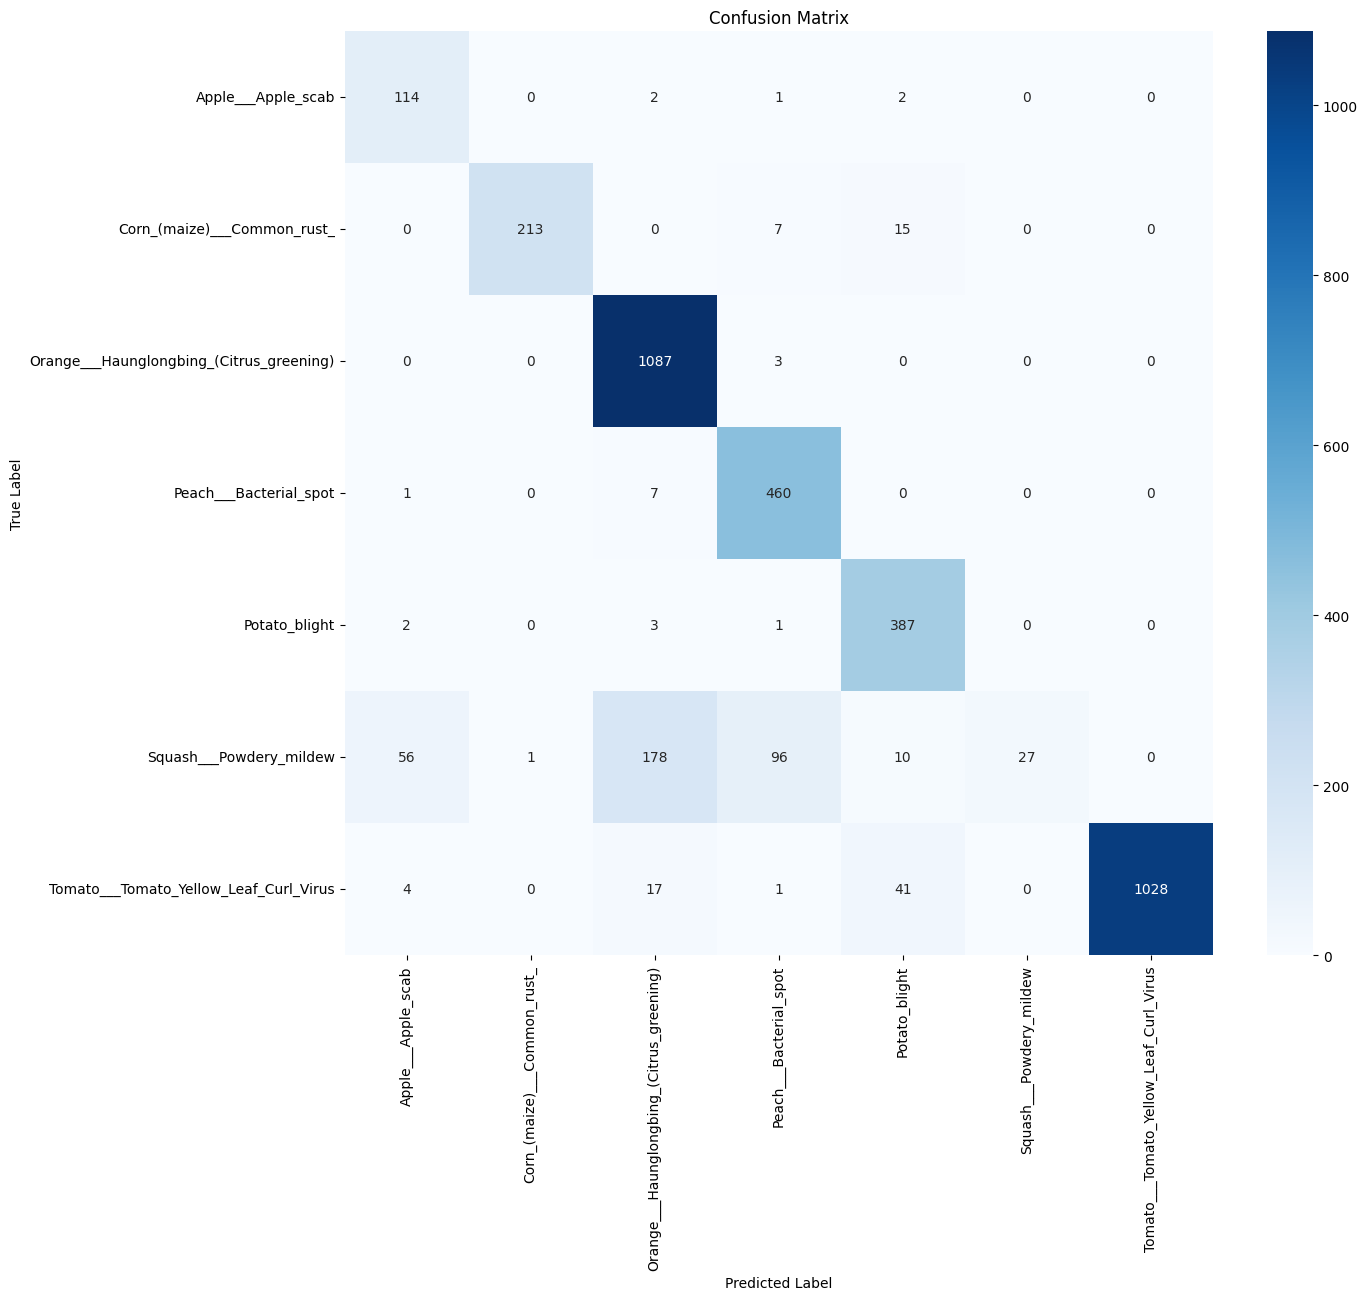

In [21]:
# Confusion Matrix and Classification Report
plt.figure(figsize=(14, 12))
conf_matrix = confusion_matrix(test_true_labels, test_predicted_labels)
class_names = list(class_labels_dict.keys())
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
print(classification_report(test_true_labels, test_predicted_labels, target_names=class_names))

                                          precision    recall  f1-score   support

                      Apple___Apple_scab       0.64      0.96      0.77       119
             Corn_(maize)___Common_rust_       1.00      0.91      0.95       235
Orange___Haunglongbing_(Citrus_greening)       0.84      1.00      0.91      1090
                  Peach___Bacterial_spot       0.81      0.98      0.89       468
                           Potato_blight       0.85      0.98      0.91       393
                 Squash___Powdery_mildew       1.00      0.07      0.14       368
  Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      0.94      0.97      1091

                                accuracy                           0.88      3764
                               macro avg       0.88      0.83      0.79      3764
                            weighted avg       0.90      0.88      0.85      3764



In [22]:
model.save('PLD_T4_model_final.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
